# 6. Training a CNN

Your coding task for this week is to train a small CNN on the MNIST data set that we used so far.

For this, we first load the data (the following four cells are the same as last week):

In [1]:
import torch
torch.manual_seed(0) # to ensure reproducibiltiy

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True, parser='auto')

In [4]:
from sklearn.model_selection import train_test_split
X_scaled = (X/255).astype('float32').values
y = y.astype('long').values
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)
X_train.shape, y_train.shape

((59500, 784), (59500,))

In [5]:
train_x = torch.Tensor(X_train).float().to(device)
test_x = torch.Tensor(X_test).float().to(device)
train_y = torch.Tensor(y_train).long().to(device)
test_y = torch.Tensor(y_test).long().to(device)
train_x.shape

torch.Size([59500, 784])

To make the input ready for a CNN, we need to bring the image again to 28x28 square shape and add a color dimension of 1 (since the image is greyscale).

In [6]:
torch_X_train = train_x.view(-1, 1, 28,28).float()
torch_X_test = test_x.view(-1, 1, 28,28).float()
torch_X_train.shape

torch.Size([59500, 1, 28, 28])

We are now ready to define a small CNN

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(1, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(4*13*13, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(-1, 4*13*13)
        return self.fc(x)

Let's now train the model (same code as last week again)

In [8]:
def train(model):
    model.to(device)            # copy the model to the device 
    model.train()
    
    no_epochs = 30
    learning_rate = 0.1
    
    loss_func = nn.CrossEntropyLoss()  
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    losses = []
    for iteration in range(no_epochs):
        
        optimizer.zero_grad()
        y_hat = model(torch_X_train) # we predict on all data points (= batch gradient descent)
        
        loss = loss_func(y_hat, train_y) # calculate the loss
        loss.backward() # backpropagate the loss to calculate gradients
        optimizer.step() # update the weights using these gradients 
    
        losses.append(loss.item())
        if iteration % 4 == 0:
            print(f"Loss in epoch {iteration} is {loss.item()}")

    return losses

In [9]:
cnn = CNN()
losses = train(cnn)

Loss in epoch 0 is 2.289332151412964
Loss in epoch 4 is 2.203684091567993
Loss in epoch 8 is 2.0622024536132812
Loss in epoch 12 is 1.7878761291503906
Loss in epoch 16 is 1.381054401397705
Loss in epoch 20 is 1.0158435106277466
Loss in epoch 24 is 0.7930989861488342
Loss in epoch 28 is 0.6659960746765137


Text(0, 0.5, 'loss')

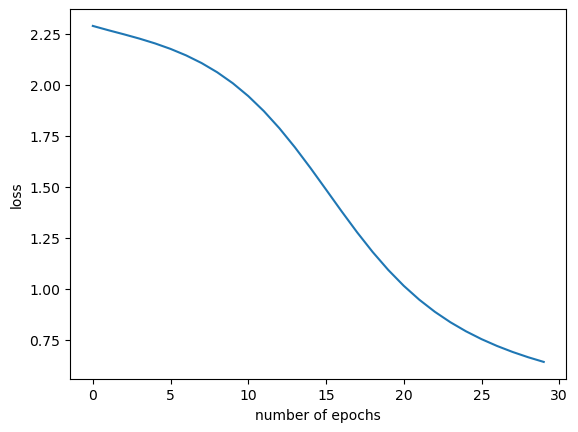

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(0, len(losses)), losses)
plt.xlabel('number of epochs')
plt.ylabel('loss')

And predict on the test data:

In [11]:
def evaluate(model):
    model.eval() 
    y_pred = model(torch_X_test)
    predicted = torch.argmax(y_pred.data, 1)
    correct = (predicted == test_y).sum().item()
    accuracy = correct / len(torch_X_test)
    
    print(f"Accuarcy is {100. * accuracy}%")

In [12]:
evaluate(cnn)

Accuarcy is 84.89523809523808%


### Coding Tasks:

We want to change now the CNN a little bit to check if we can increase the accuracy, try the following steps:
1. Try to understand why the number `4*13*13` is there in the CNN definition?
2. Increase the kernel size of the CNN layer to 5 and add a padding of 1 (you need to change the aforementioned number).
3. Add a second CNN layer that comes after the first CNN layer. This new layer has kernel size 5, and a feature map size of 8. Set the padding to 0 for both CNN layers.
4. Add a second fully connected layer, just before the last layer. This layer should have 84 neurons.

Every step, retrain the network to see if your changes work.

If you have time left, read and try to understand PyTorch's offical CNN tutorial, which can be found [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).